In [184]:
import jax
import jax.numpy as jnp
from diffrax import ODETerm, SaveAt, Tsit5, diffeqsolve
import matplotlib.pyplot as plt

In [185]:
N = 50
L = 1.0
dx = L / N
dy = L / N
x = jnp.linspace(0, L, N, endpoint=False)
y = jnp.linspace(0, L, N, endpoint=False)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# parameters
f = 1e-4       # Coriolis parameter
nu = 1e-3      # Viscosity
dt = 0.1       # Time step (for plotting)
t_final = 100  # Final time
n_iters = 5
tol = 1e-6


In [186]:
# helper functions are computed using central differences with periodic boundary conditions
def laplacian(f):
    return (
        (jnp.roll(f, -1, axis=0) - 2 * f + jnp.roll(f, 1, axis=0)) / dx**2 +
        (jnp.roll(f, -1, axis=1) - 2 * f + jnp.roll(f, 1, axis=1)) / dy**2
    )

def grad_x(f):
    return (jnp.roll(f, -1, axis=0) - jnp.roll(f, 1, axis=0)) / (2 * dx)

def grad_y(f):
    return (jnp.roll(f, -1, axis=1) - jnp.roll(f, 1, axis=1)) / (2 * dy)

def divergence(u, v):
    return grad_x(u) + grad_y(v)

In [187]:
'''
def solve_poisson(rhs, n_iters, tol):
# solve poisson equation using an Jacobi iteration method
    # solves ∇²p = rhs for pressure p
    # where rhs is the divergence of the velocity field
    p = jnp.zeros_like(rhs)  # initial guess for pressure
    for _ in range(n_iters):
        p_new = (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0) +
            jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1) -
            dx**2 * rhs) / 4.0
        
        if jnp.max(jnp.abs(p_new - p)) < tol:
            break
        p = p_new
    return p
'''

def solve_poisson(rhs, n_iters, tol):
    p = jnp.zeros_like(rhs)
    for i in range(n_iters):
        p_new = (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0) +
                 jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1) -
                 dx**2 * rhs) / 4.0

        max_diff = jnp.max(jnp.abs(p_new - p))
        if jnp.isnan(max_diff):
            print(f"NaN detected at iteration {i}")
            break

        if max_diff < tol:
            print(f"Poisson solver converged at iter {i}, max diff = {max_diff}")
            break

        p = p_new

    return p


def pressure_correction(u, v, tol):
    # solves ∇²p = ∇·v for each intermediate velocity field (not divergenge-free)
    # used to ensure that the velocity field (u, v) is divergence-free (incompressible)
    div = divergence(u, v)
    
    # for debugging purposes
    print("Max divergence:", jnp.max(jnp.abs(div)))
    print("Any NaNs in divergence?", jnp.isnan(div).any())

    p = solve_poisson(div, n_iters, tol)

    # correct the velocity field using the pressure gradient
    u_corrected = u - grad_x(p)
    v_corrected = v - grad_y(p)
    return u_corrected, v_corrected



In [188]:
def navier_stokes(t, state, args):
    u, v = jnp.split(state, 2, axis=0)
    u = u.reshape((N, N))
    v = v.reshape((N, N))

    # Advection terms
    du_adv = u * grad_x(u) + v * grad_y(u)
    dv_adv = u * grad_x(v) + v * grad_y(v)

    # Laplacian (viscosity)
    du_visc = nu * laplacian(u)
    dv_visc = nu * laplacian(v)

    # Background pressure gradients (assume ∂p/∂x = px, ∂p/∂y = py)
    # We've used constant pressure gradients for simplicity
    px, py = 1e-3, -1e-3

    du_dt = -du_adv - px + f * v + du_visc
    dv_dt = -dv_adv - py - f * u + dv_visc

    # Combine and reshape for solver
    return jnp.concatenate([du_dt.ravel(), dv_dt.ravel()])


In [189]:
# initial_conditions
u0 = jnp.zeros((N, N))
v0 = jnp.zeros((N, N))
# Add small perturbation
#u0 = u0.at[N//2 - 5:N//2 + 5, N//2 - 5:N//2 + 5].set(0.1)
u0 = jnp.tile(y, (N, 1)).T  # u(x,y) = y
v0 = jnp.tile(x, (N, 1)) 
initial_condition = jnp.concatenate([u0.ravel(), v0.ravel()])
# 


# solve using diffrax
# note: diffrax only solves the navier stokes equation without solving for pressure
# at each time step. So the resulting velocity field may accumulate divergence over time.
# We add a pressure correction step after the obtaining the solution to ensure 
# incompressibility. (See visualization step).
term = ODETerm(navier_stokes)
solver = Tsit5()
saveat = SaveAt(ts=jnp.arange(0, t_final, dt))
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=t_final,
    dt0=dt,
    y0=initial_condition,
    saveat=saveat,
)


Max divergence: 48.0
Any NaNs in divergence? False
Max divergence: nan
Any NaNs in divergence? True
NaN detected at iteration 0


/Users/jessicazhang/Documents/differential-envopt/venv/lib/python3.13/site-packages/matplotlib/quiver.py:676: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/jessicazhang/Documents/differential-envopt/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


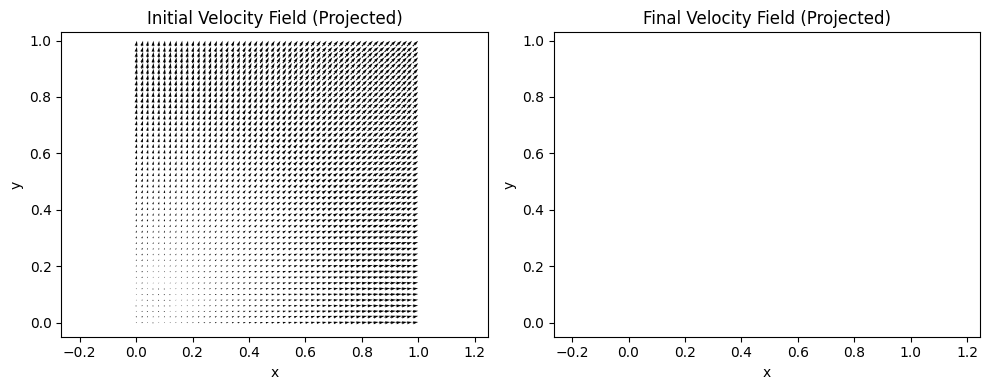

In [190]:
# Visualization
# get initial and final states
u_init, v_init = jnp.split(sol.ys[0], 2, axis=0)
u_final, v_final = jnp.split(sol.ys[-1], 2, axis=0)

# reshape from flat to 2D arrays for plotting
u_init = u_init.reshape((N, N))
v_init = v_init.reshape((N, N))
u_final = u_final.reshape((N, N))
v_final = v_final.reshape((N, N))

# add pressure correction to ensure incompressibility
u_init_proj, v_init_proj = pressure_correction(u0, v0, tol)
u_final_proj, v_final_proj = pressure_correction(u_final, v_final, tol)

# Create grid for quiver plot
x = jnp.linspace(0, L, N, endpoint=False)
y = jnp.linspace(0, L, N, endpoint=False)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# initial velocity
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.quiver(X, Y, u_init_proj, v_init_proj)
plt.title("Initial Velocity Field (Projected)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

# final velocity field
plt.subplot(1, 2, 2)
plt.quiver(X, Y, u_final_proj, v_final_proj)
plt.title("Final Velocity Field (Projected)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')

plt.tight_layout()
plt.show()
